In [2]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import json
import talib as talib
from talib import MA_Type, OBV, ATR, WCLPRICE, AVGPRICE, STDDEV
from matplotlib import pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
#from matplotlib.pylab import date2num


In [3]:
df = pd.read_csv (r'../CSV/oneStockAAPL.csv', sep=',')
df.drop('Dividends', axis=1, inplace=True)
df.drop('Stock Splits', axis=1, inplace=True)
print(df)


        Timestamp        Open        High         Low       Close     Volume  \
0      1980-12-12    0.100453    0.100890    0.100453    0.100453  469033600   
1      1980-12-15    0.095649    0.095649    0.095213    0.095213  175884800   
2      1980-12-16    0.088661    0.088661    0.088224    0.088224  105728000   
3      1980-12-17    0.090408    0.090845    0.090408    0.090408   86441600   
4      1980-12-18    0.093029    0.093466    0.093029    0.093029   73449600   
...           ...         ...         ...         ...         ...        ...   
10357  2022-01-10  169.080002  172.500000  168.169998  172.190002  106765600   
10358  2022-01-11  172.320007  175.179993  170.820007  175.080002   76138300   
10359  2022-01-12  176.119995  177.179993  174.820007  175.529999   74805200   
10360  2022-01-13  175.779999  176.619995  171.789993  172.190002   84505800   
10361  2022-01-14  171.339996  173.779999  171.089996  173.070007   80355000   

      Symbol  
0       AAPL  
1       A

In [4]:
# Functions
def checkNonesString(df):
    # CHECK Object column for "None" strings.
    print(df[df['Symbol'].str.contains('None')].any())
    

def checkNans(df):
    # Check if there are NaNs
    print("-----IS NA per COL-------")
    print("Doesn't seem to be working")
    print(df[df.isna().any(axis=1)].sum())

    print("-----IS NA per COL-------")
    print(df.isna().sum())

    print("------printing sum of Nans for each column------")
    for col in df.columns:
        print(col + ": " + str(df[col].isnull().sum()))
        
        
def checkInfs(df):
    print("-------total amount of Infs per Column-----------")
    print(df.groupby(np.isinf(df["Open"])).count())

    print("-------total amount of Infs-----------")
    count = np.isinf(df["Open"]).values.sum()
    print("It contains " + str(count) + " infinite values")


def printDataframe(df):
    # Prints
    print("-----DATAFRAME-------")
    print(df.head(10))

    print("-----SHAPE-------")
    print(df.shape)

    print("-----COLUMNS-------")
    print(df.columns)

    print("-----DATATYPES-------")
    print(df.dtypes)



In [2]:
# Casting Timestamp to type datetime64[ns]
df['Timestamp'] = df['Timestamp'].astype('datetime64[ns]')
# Adding week number, to be able to derived the Weekly labels.
df.insert(1, 'Week_Number', df['Timestamp'].dt.week)

# Creating labels
for ticker in df["Symbol"]:
    df["Close1d%"] = df["Close"].pct_change(periods=-1).shift(periods=0)
    df["Close5d%"] = df["Close"].pct_change(periods=-5).shift(periods=0)
    df["Close10d%"] = df["Close"].pct_change(periods=-10).shift(periods=0)
    df["Close15d%"] = df["Close"].pct_change(periods=-15).shift(periods=0)
    df["Close20d%"] = df["Close"].pct_change(periods=-20).shift(periods=0)

printDataframe(df)

NameError: name 'df' is not defined

In [5]:
# Adding Numerical indicators/features in a for loop, for all stocks.
list_of_stocks = df['Symbol'].unique()
list_to_category = []
list_to_percentage = []
print(list_of_stocks.size)
for ticker in list_of_stocks:
    print(str(ticker))
# it neeeds to know how to access the right rows, those beloning to the right ticker.
#-------- Price comparable indicators------------
    
    # BB
    df["BB upper"], df["BB middle"], df["BB lower"] = talib.BBANDS(df["Close"], matype=MA_Type.T3)
    list_to_category.extend(["BB upper", "BB lower"])
    list_to_percentage.extend(["BB upper", "BB lower"])    

    # SMA 0-50
    for i in range(5,25,5):
        tempColName = "SMA" + str(i)
        list_to_category.append(tempColName)
        list_to_percentage.append(tempColName)
        df[tempColName] = talib.SMA(df["Close"], i)

    # SMA 50-300
    for i in range(50,300,50):
        tempColName = "SMA" + str(i)
        list_to_category.append(tempColName)
        list_to_percentage.append(tempColName)
        df[tempColName] = talib.SMA(df["Close"], i)
        
    # Weighted Closed Price
    df["WCLPRICE"] = WCLPRICE(df["High"], df["Low"], df["Close"])
    list_to_category.append("WCLPRICE")
    list_to_percentage.append("WCLPRICE")

    # AVG Price
    df["AVGPRICE"] = AVGPRICE(df["Open"], df["High"], df["Low"], df["Close"])
    list_to_category.append("AVGPRICE")
    list_to_percentage.append("AVGPRICE")
    
    # STD deviation
    df["STD-5/1"] = STDDEV(df["Close"], timeperiod=5, nbdev=1)
    df["STD-5/2"] = STDDEV(df["Close"], timeperiod=5, nbdev=2)
    df["STD-10/1"] = STDDEV(df["Close"], timeperiod=10, nbdev=1)
    df["STD-10/2"] = STDDEV(df["Close"], timeperiod=10, nbdev=2)
    list_to_category.extend(["STD-5/1", "STD-5/2", "STD-10/1", "STD-10/2"])
    list_to_percentage.extend(["STD-5/1", "STD-5/2", "STD-10/1", "STD-10/2"])

#-------- Other indicators------------
    
    # OBV
    df["OBV"] = OBV(df["Close"], df["Volume"])
    
    # ATR
    df["ATR14"] = ATR(df["High"], df["Low"], df["Close"], timeperiod=14)
    df["ATR5"] = ATR(df["High"], df["Low"], df["Close"], timeperiod=5)

    # RSI
    df["RSI"] = talib.RSI(df["Close"])
    
    # Momentum
    df["Momentum"] = talib.MOM(df["Close"], timeperiod=5)

    # MACD
    df["macd"], df["macd_signal"], df["macd_hist"] = talib.MACD(df['Close'])

NameError: name 'df' is not defined

In [18]:
# A checking of values validity
checkNonesString(df)
checkNans(df)
checkInfs(df)
printDataframe(df)

Timestamp      False
Week_Number    False
Open           False
High           False
Low            False
Close          False
Volume         False
Symbol         False
Close1d%       False
Close5d%       False
Close10d%      False
Close15d%      False
Close20d%      False
BB upper       False
BB middle      False
BB lower       False
SMA5           False
SMA10          False
SMA15          False
SMA20          False
SMA50          False
SMA100         False
SMA150         False
SMA200         False
SMA250         False
WCLPRICE       False
AVGPRICE       False
STD-5/1        False
STD-5/2        False
STD-10/1       False
STD-10/2       False
OBV            False
ATR14          False
ATR5           False
RSI            False
Momentum       False
macd           False
macd_signal    False
macd_hist      False
dtype: bool
-----IS NA per COL-------
Doesn't seem to be working
Week_Number                                                 7058
Open                                               

C:\Users\Eric\AppData\Local\Temp/ipykernel_7628/1157756439.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df[df.isna().any(axis=1)].sum())


C:\Users\Eric\AppData\Local\Temp/ipykernel_7628/1157756439.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df[df.isna().any(axis=1)].sum())
No handles with labels found to put in legend.


-----IS NA per COL-------
Doesn't seem to be working
Week_Number                                                  529
Open                                                 3503.099991
High                                                 3542.830002
Low                                                  3473.610001
Close                                                3509.430008
Volume                                                1799210800
Symbol         AAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAAPLAA...
Close1d%                                               -0.009347
Close5d%                                                -0.00639
Close10d%                                               0.073066
Close15d%                                              -0.012428
Close20d%                                                    0.0
BB upper                                             3615.238366
BB middle                                            3522.854661
BB lower                             

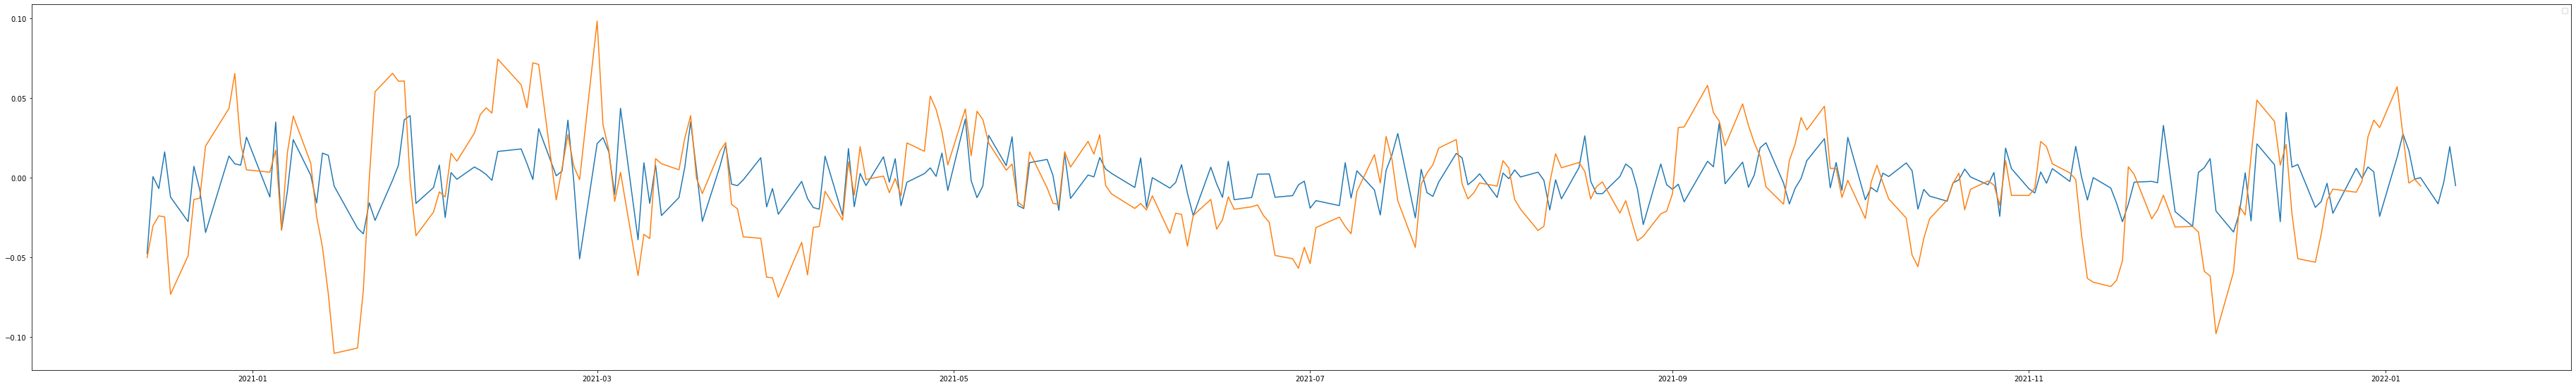

In [19]:
# Example plotting
df_plot = df[df["Timestamp"] > '2020-12-12']
df_plot.index = df_plot["Timestamp"]

checkNans(df_plot)

fig = plt.figure()
fig.set_size_inches((50, 36))
ax_rsi = fig.add_axes((0, 0.24, 1, 0.2))

# Plotting the RSI boundaries
#ax_rsi.plot(df_plot.index, [70] * len(df_plot.index), label="overbought")
#ax_rsi.plot(df_plot.index, [30] * len(df_plot.index), label="oversold")
#ax_rsi.plot(df_plot.index, df_plot["RSI"], label="rsi")

# Plotting the BB 
#ax_rsi.plot(df_plot.index,df_plot["BB upper"],  label="BBhigh", color ="purple")
#ax_rsi.plot(df_plot.index,df_plot["BB lower"], label="BBlow", color ="purple")
#ax_rsi.plot(df_plot.index,df_plot["BB middle"], label="BBmiddle", color ="purple")

# Plotting Volume
#ax_rsi.plot(df_plot.index,(df_plot["OBV"] / 1000000000), label="OBV", color ="teal")


# Plotting OBV
#ax_rsi.plot(df_plot.index, (df_plot["OBV"] / 1000000000), label="OBV", color ="teal")
ax_rsi.plot(df_plot.index, df_plot["Close1d%"])
ax_rsi.plot(df_plot.index, df_plot["Close5d%"])

# plotting the Price
#ax_rsi.plot(df_plot.index, (df_plot["Volume"] / 10000000), label = "Vol", color= "black")  # density=False would make counts
#ax_rsi.plot(df_plot["Close"], label = "Price")
#ax_rsi.plot((df_plot["Volume"] / 10000000), label="Vol", color ="Black")
ax_rsi.legend()

In [20]:
# Categoriacl feature engineering represented as binary
print(list_to_category)
#print(list_to_category)
for col in list_to_category:
    under = "Under " + col 
    over = "Over " + col 
    df[under] = df[col] <= df["Close"]
    df[over] = df[col] > df["Close"]
    df[under] = df[under].astype(int)
    df[over] = df[over].astype(int)
    
print(df.columns)
print(df.head(30))


['BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2']
Index(['Timestamp', 'Week_Number', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Symbol', 'Close1d%', 'Close5d%', 'Close10d%', 'Close15d%', 'Close20d%',
       'BB upper', 'BB middle', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20',
       'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE',
       'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2', 'OBV', 'ATR14', 'ATR5',
       'RSI', 'Momentum', 'macd', 'macd_signal', 'macd_hist', 'Under BB upper',
       'Over BB upper', 'Under BB lower', 'Over BB lower', 'Under SMA5',
       'Over SMA5', 'Under SMA10', 'Over SMA10', 'Under SMA15', 'Over SMA15',
       'Under SMA20', 'Over SMA20', 'Under SMA50', 'Over SMA50',
       'Under SMA100', 'Over SMA100', 'Under SMA150', 'Over SMA150',
       'Under SMA200', 'Over SMA200', 'Under SMA250', 'Over SMA

In [21]:
# % difference from price Features
print(list_to_percentage)
for col in list_to_percentage:
    col_name = "% " + col 
    df[col_name] = df[col] / df["Close"]
    #df[col_name] = df["Close"] / df[col]
    print(df[col_name])

['BB upper', 'BB lower', 'SMA5', 'SMA10', 'SMA15', 'SMA20', 'SMA50', 'SMA100', 'SMA150', 'SMA200', 'SMA250', 'WCLPRICE', 'AVGPRICE', 'STD-5/1', 'STD-5/2', 'STD-10/1', 'STD-10/2']
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
10357    1.052196
10358    1.011565
10359    1.008619
10360    1.025795
10361    1.017593
Name: % BB upper, Length: 10362, dtype: float64
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
10357    0.983465
10358    0.979274
10359    0.972883
10360    0.990115
10361    0.984628
Name: % BB lower, Length: 10362, dtype: float64
0             NaN
1             NaN
2             NaN
3             NaN
4        1.004691
           ...   
10357    1.011650
10358    0.989673
10359    0.987831
10360    1.007213
10361    1.003132
Name: % SMA5, Length: 10362, dtype: float64
0             NaN
1             NaN
2             NaN
3             NaN
4             N

In [23]:
# correlation calculation
feature_corr = df.copy().corr()

# Sorting
sortedDesc1d = feature_corr["Close1d%"].sort_values(ascending=False) 
sortedDesc5d = feature_corr["Close5d%"].sort_values(ascending=False) 
sortedDesc10d = feature_corr["Close10d%"].sort_values(ascending=False) 
sortedDesc15d = feature_corr["Close15d%"].sort_values(ascending=False) 
sortedDesc20d = feature_corr["Close20d%"].sort_values(ascending=False) 

# Printing
print(sortedDesc1d.head(10))
print(sortedDesc5d.head(10))
print(sortedDesc10d.head(10))
print(sortedDesc15d.head(10))
print(sortedDesc20d.head(10))

Close1d%         1.000000
Close5d%         0.454091
Close10d%        0.318229
Close15d%        0.272722
Close20d%        0.236484
Over SMA15       0.027927
Over STD-10/2    0.027784
Over SMA20       0.027087
Over SMA50       0.024102
% STD-10/2       0.023665
Name: Close1d%, dtype: float64
Close5d%          1.000000
Close10d%         0.713822
Close15d%         0.577406
Close20d%         0.517882
Close1d%          0.454091
Under STD-10/1    0.058604
Over SMA50        0.056093
% STD-5/2         0.055989
% STD-5/1         0.055989
% SMA50           0.044650
Name: Close5d%, dtype: float64
Close10d%     1.000000
Close15d%     0.824293
Close20d%     0.720433
Close5d%      0.713822
Close1d%      0.318229
Over SMA50    0.063408
% SMA50       0.058651
% STD-10/2    0.054681
% STD-10/1    0.054681
Over SMA20    0.054111
Name: Close10d%, dtype: float64
Close15d%     1.000000
Close20d%     0.875825
Close10d%     0.824293
Close5d%      0.577406
Close1d%      0.272722
% SMA50       0.069556
% STD-5/

In [24]:
# Exporting as CSV 
#df.to_csv(r'../CSV/FeaturesAAPL.csv', sep= ",", index = False)